# Forecasting metrics: case 2

In this notebooks forecast metrics for all models fitted for the simulation case 2 are calculated and saved to a single file.

In [42]:
import os
import sys
import pickle

import tensorflow as tf
import pandas as pd

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Metrics.metrics import get_model_metrics
from DataSimulation.utils import plot_fit
from Transformers.model import Forecaster


## Data

In [43]:
case_path = os.path.join(src_path, "Notebooks", "data_generation_and_models_fitting", "case_2")
case="case_2"

In [44]:
data = pd.read_csv(os.path.join(case_path, 'data.csv'), header=None)
data.head()

0     1    2     3     4     5    6     7     8       9   ...     90  \
0   0.0  11.0  4.0  43.0  31.0  15.0  3.0  56.0   7.0   322.0  ...  233.0   
1  35.0   7.0  4.0  14.0  26.0  13.0  0.0  51.0   4.0   232.0  ...   53.0   
2  10.0   4.0  5.0   9.0  43.0  44.0  4.0  39.0   3.0   416.0  ...   39.0   
3  33.0   7.0  4.0  23.0  13.0  33.0  0.0  38.0  11.0   912.0  ...  215.0   
4   4.0   4.0  4.0  17.0  16.0  21.0  2.0  52.0  14.0  3409.0  ...   50.0   

      91     92     93    94   95     96    97     98     99  
0  109.0   91.0   65.0  16.0  3.0  123.0  17.0  117.0   39.0  
1    4.0   64.0  152.0  14.0  2.0  211.0   4.0  547.0   63.0  
2   51.0   48.0   91.0  21.0  6.0    7.0   1.0  688.0   50.0  
3    7.0   26.0  377.0  13.0  2.0   36.0   0.0  187.0   88.0  
4   37.0  231.0  321.0  14.0  3.0   30.0   0.0  343.0  171.0  

[5 rows x 100 columns]

In [45]:
test_size = 12
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(188, 100)
(12, 100)


In [46]:
metrics = {}
metrics_statistics = {}

## Sarima model

In [47]:
with open(os.path.join(case_path, "sarima.pkl"), "rb") as file:
    sarima_model = pickle.load(file)

In [48]:
sarima_prediction = sarima_model.predict(12)

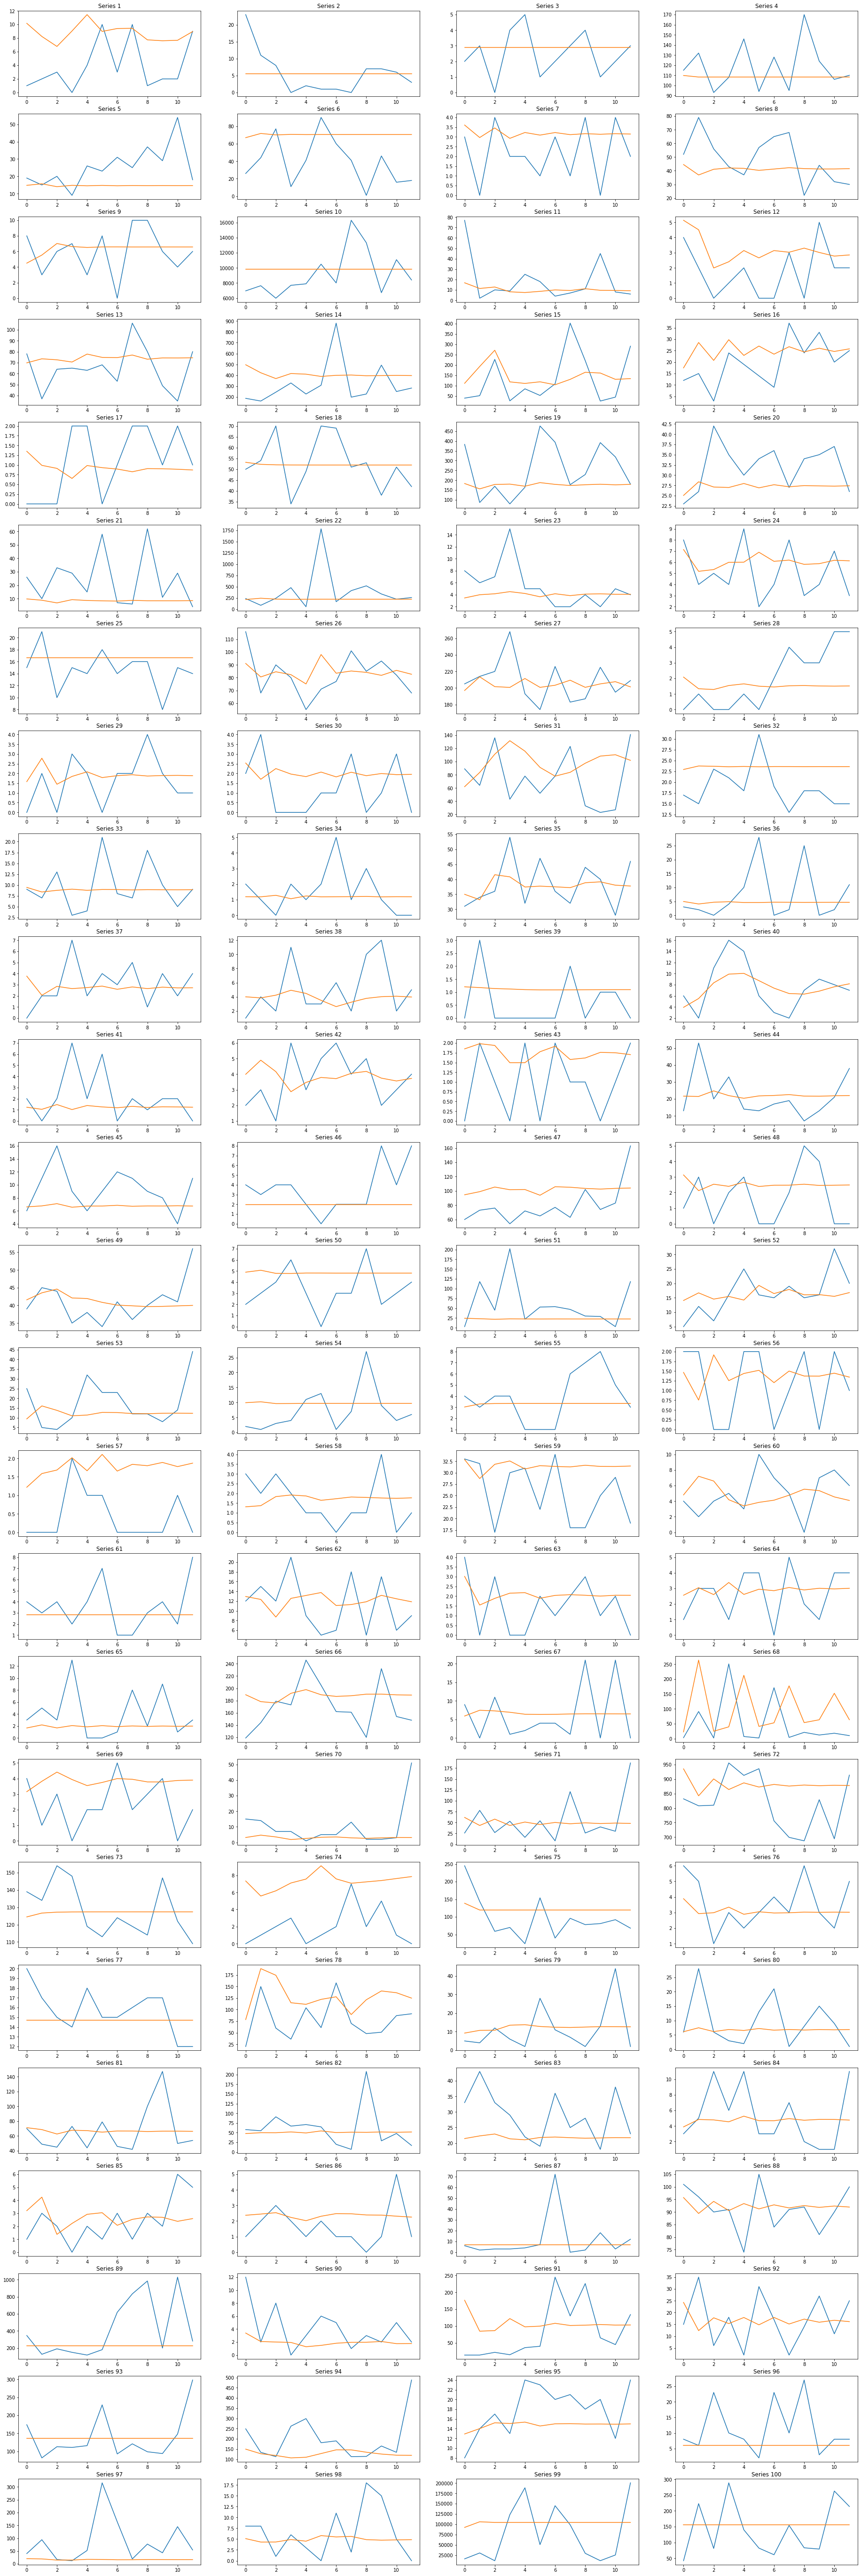

In [49]:
plot_fit(test_data, sarima_prediction, predicted=True, cols=4)

In [50]:
sarima_metrics, sarima_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=sarima_prediction,
    train_data=train_data,
    m=1,
    model_name="sarima",
    case=case
)
metrics.update(sarima_metrics)
metrics_statistics.update(sarima_statistics)

## Poisson Autoregression model

In [51]:
with open(os.path.join(case_path, "poisson_autoregression.pkl"), "rb") as file:
    poisson_ar_model = pickle.load(file)

In [52]:
poisson_ar_prediction = poisson_ar_model.predict(12)

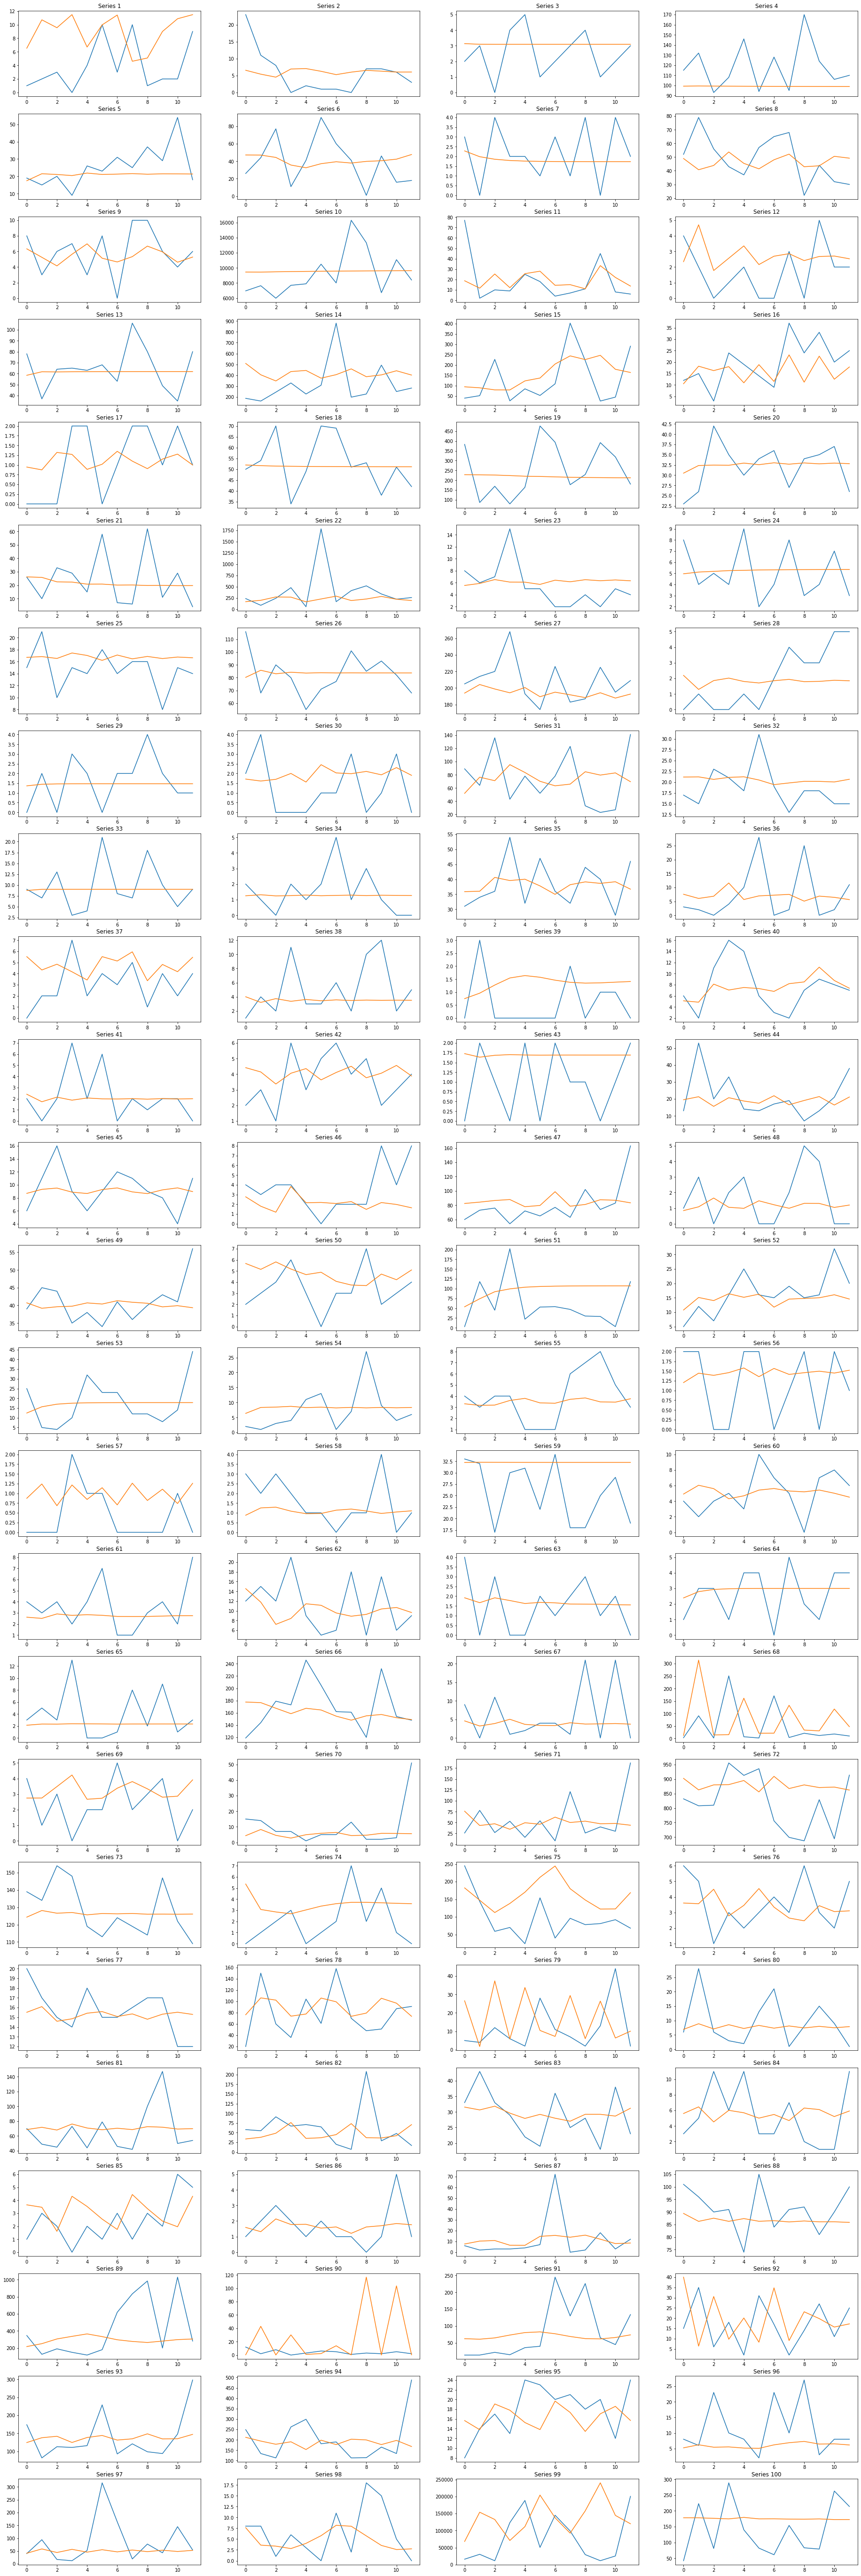

In [53]:
plot_fit(test_data, poisson_ar_prediction, predicted=True, cols=4)

In [54]:
p_ar_metrics, p_ar_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=poisson_ar_prediction,
    train_data=train_data,
    m=1,
    model_name="poisson_autorregression",
    case=case
)
metrics.update(p_ar_metrics)
metrics_statistics.update(p_ar_statistics)

## Recurrent Neural Network

The model summary in the "rnn_fit.ipynb" allows to know that the best model uses a 12 timesteps input

In [55]:
input_steps = 12

In [56]:
with open(os.path.join(case_path, "rnn_scaler.pkl"), "rb") as file:
    rnn_scaler = pickle.load(file)

In [57]:
scaled_data = rnn_scaler.transform(train_data[-input_steps:]).reshape((1,input_steps,-1))

In [58]:
rnn_model = tf.keras.models.load_model(os.path.join(case_path, "rnn.h5"))

In [59]:
rnn_prediction = rnn_model.predict(scaled_data)

1/1 [==============================] - 2s 2s/step


In [60]:
rnn_prediction = rnn_scaler.inverse_transform(rnn_prediction[0])

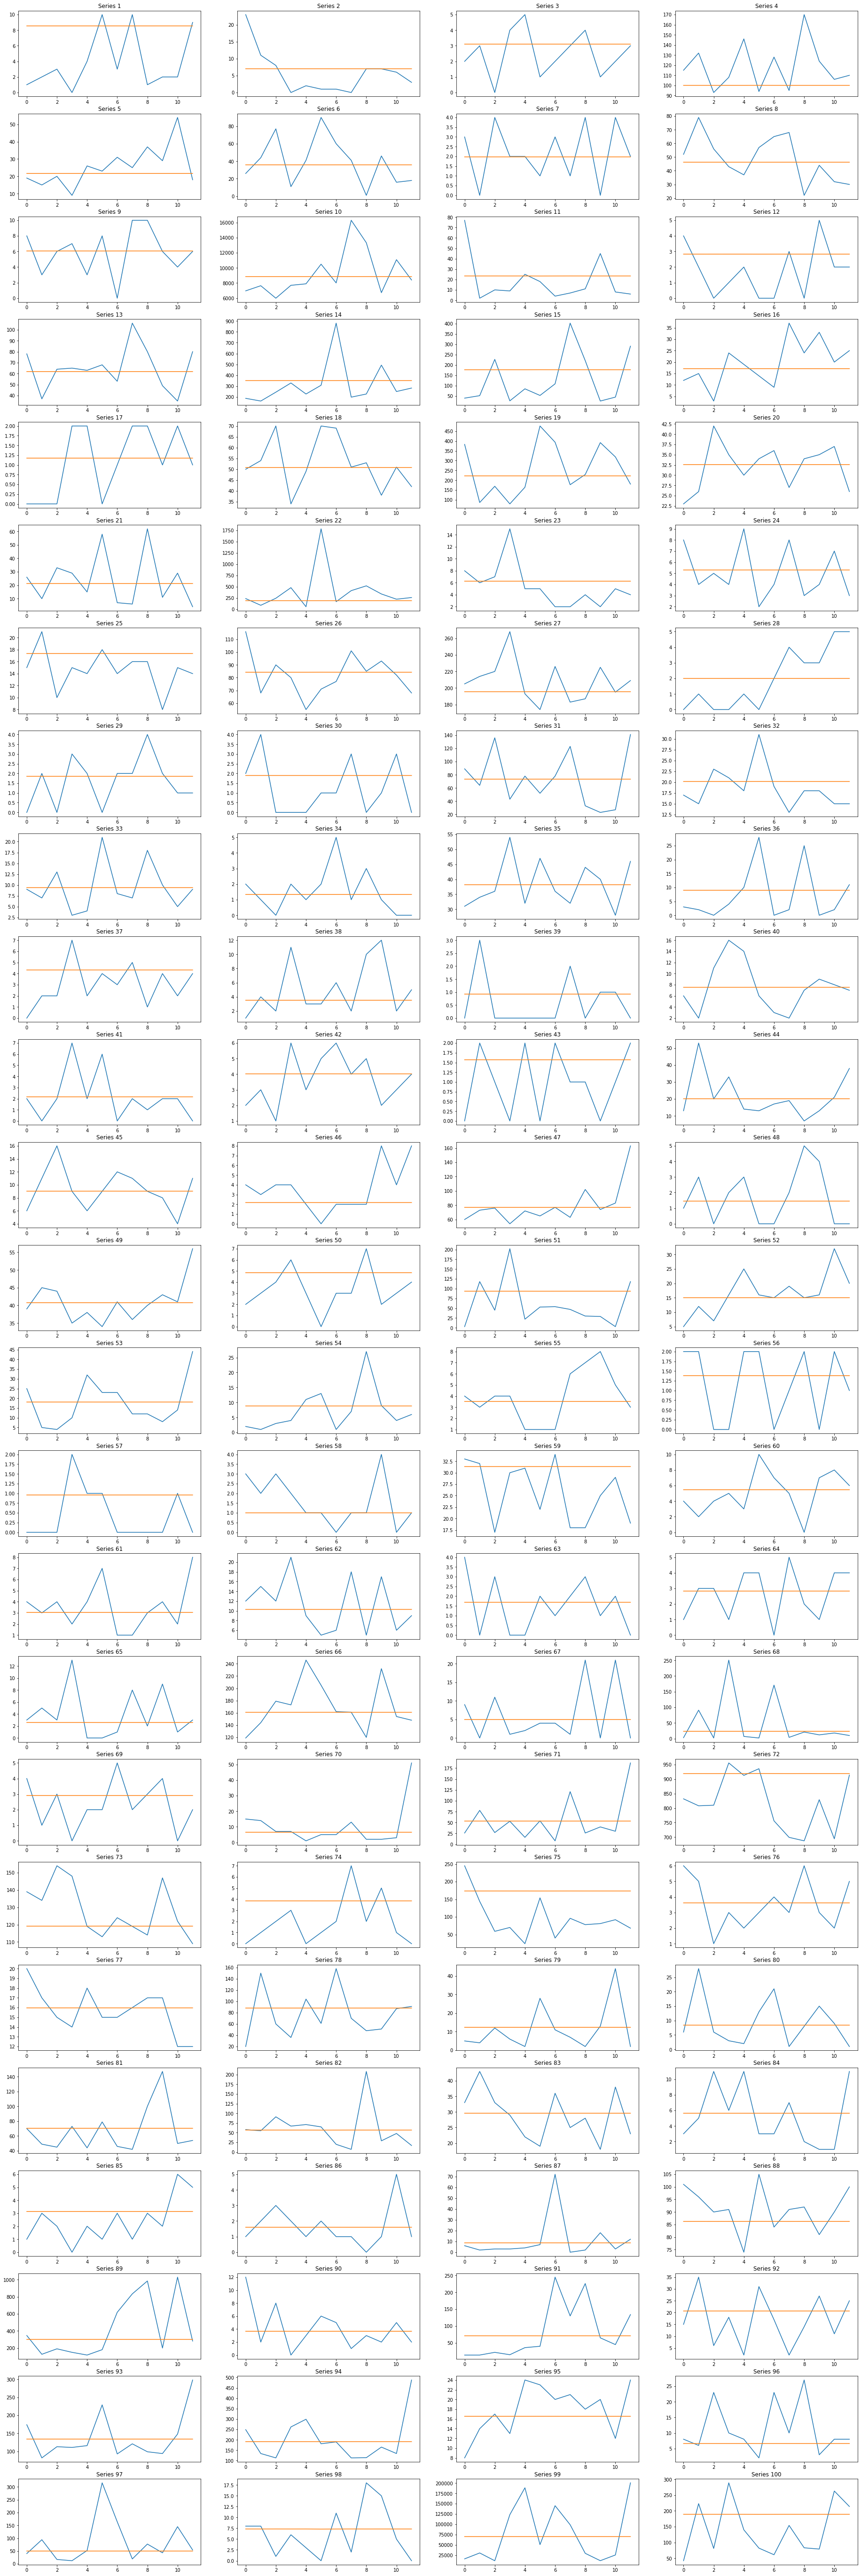

In [61]:
plot_fit(test_data, rnn_prediction, predicted=True, cols=4)

In [62]:
rnn_metrics, rnn_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=rnn_prediction,
    train_data=train_data,
    m=1,
    model_name="recurrent_neural_network",
    case=case
)
metrics.update(rnn_metrics)
metrics_statistics.update(rnn_statistics)

## Transformer model

In [63]:
with open(os.path.join(case_path, "transformer_scaler.pkl"), "rb") as file:
    transformer_scaler = pickle.load(file)

In [64]:
transformer_model = tf.keras.models.load_model(os.path.join(case_path, "transformer.tf"))

In [65]:
forecaster = Forecaster(transformer_scaler, transformer_model)

In [66]:
t_input_steps = 12
inputs = train_data[-t_input_steps:]

In [67]:
transformer_prediction = forecaster(inputs=inputs, steps=12)

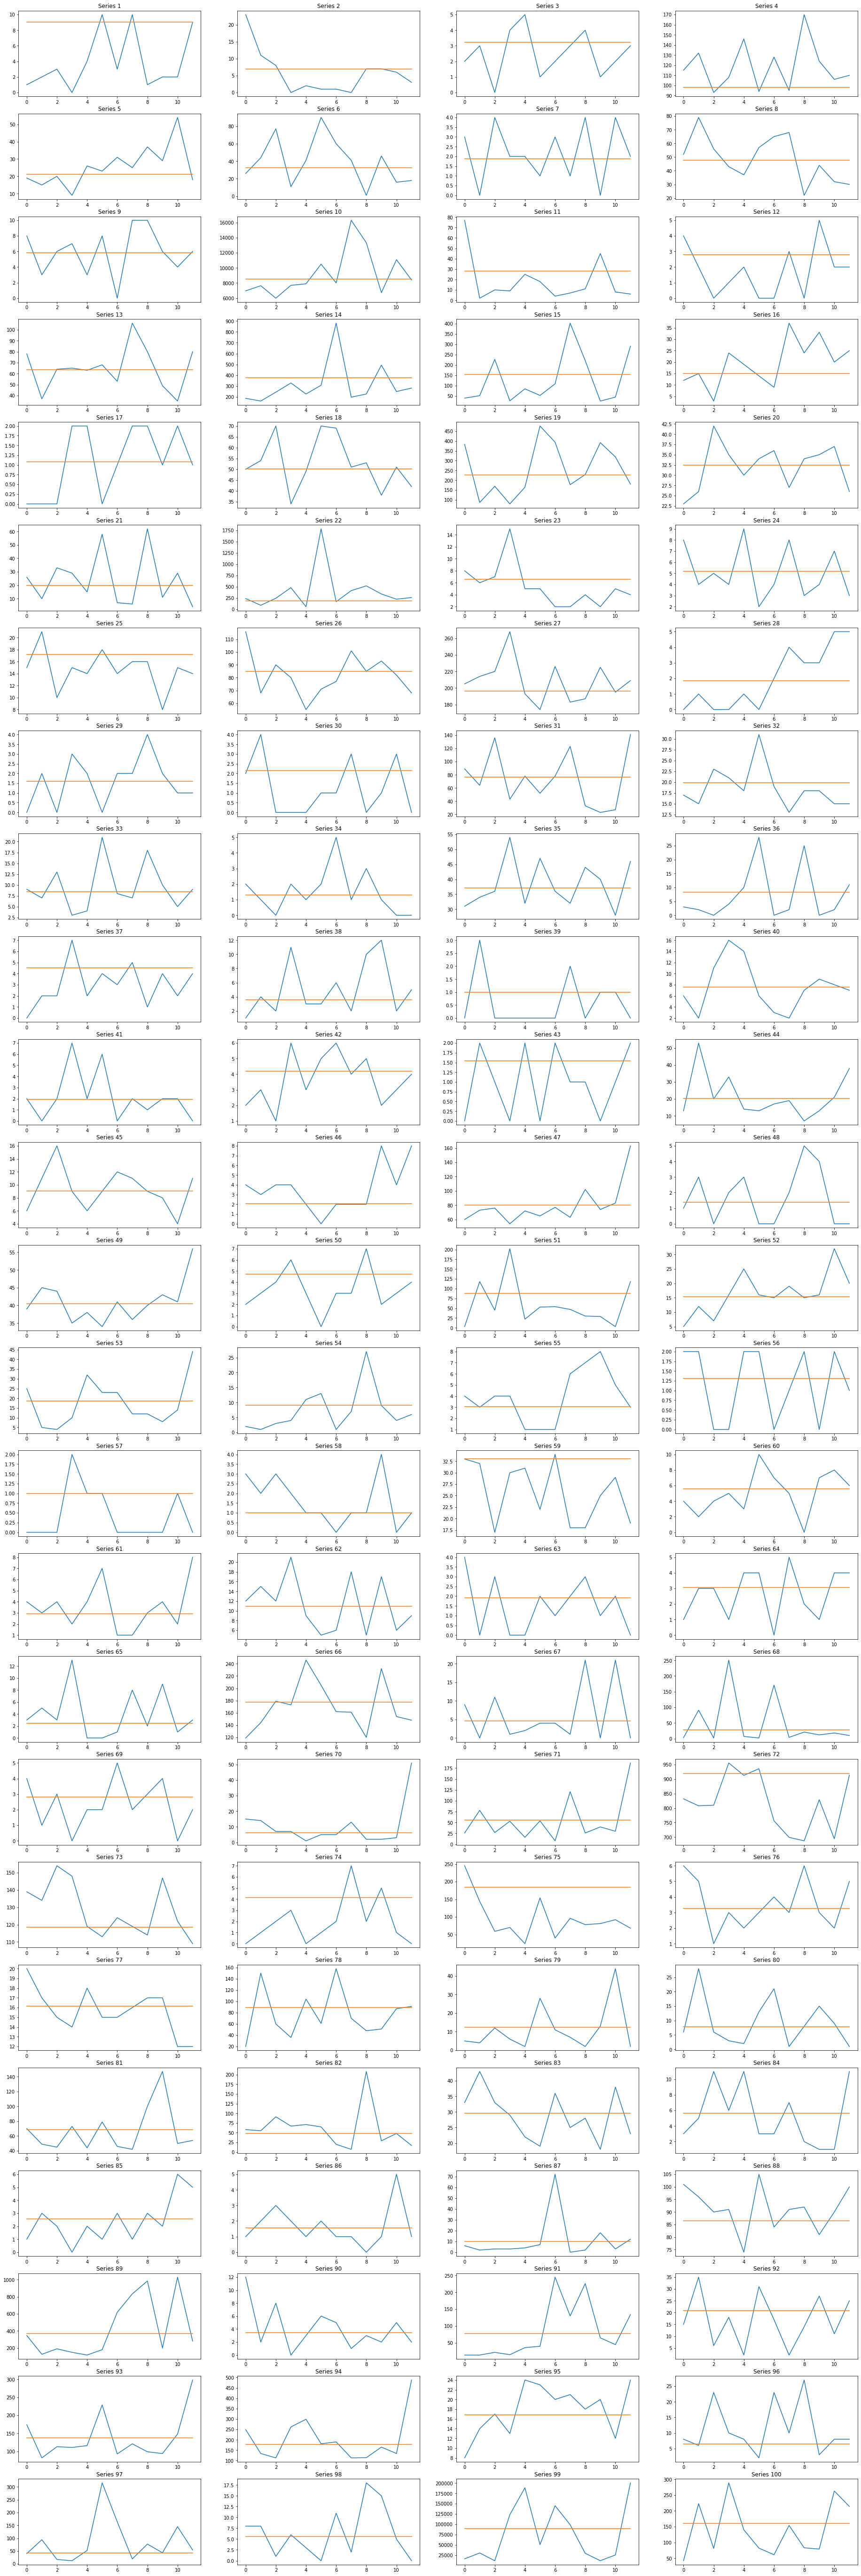

In [68]:
plot_fit(test_data, transformer_prediction, predicted=True, cols=4)

In [69]:
transformer_metrics, transformer_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=transformer_prediction,
    train_data=train_data,
    m=1,
    model_name="transformer",
    case=case
)
metrics.update(transformer_metrics)
metrics_statistics.update(transformer_statistics)

## Metrics results

In [70]:
pd.DataFrame(metrics)

sarima-case_2           poisson_autorregression-case_2            \
           sMAPE      MASE                          sMAPE      MASE   
0      97.360461  0.562209                     104.455245  0.649179   
1      92.636967  0.753149                      92.701901  0.784342   
2      52.754032  0.647379                      53.520650  0.675473   
3      14.574494  0.610511                      18.637420  0.759695   
4      52.148480  0.989803                      32.705302  0.687007   
..           ...       ...                            ...       ...   
95     62.203866  1.203804                      61.938445  1.190014   
96     98.409214  1.405756                      66.853770  1.118334   
97     89.467247  0.633365                      94.162477  0.621020   
98     87.718951  0.646877                      97.881415  0.940571   
99     53.689584  0.506928                      57.020180  0.554957   

   recurrent_neural_network-case_2           transformer-case_2            
                             sMAPE      MASE              sMAPE      MASE  
0                        99.145305  0.567187         100.053077  0.593437  
1                        89.277770  0.781365          89.264727  0.780176  
2                        53.562142  0.677071          54.934748  0.710097  
3                        18.157715  0.742655          19.119791  0.776715  
4                        33.277396  0.698755          33.698095  0.706736  
..                             ...       ...                ...       ...  
95                       57.672927  1.143241          58.257582  1.151252  
96                       67.758169  1.125751          70.509515  1.159554  
97                       84.865630  0.653503          87.067929  0.623333  
98                       87.355788  0.589957          87.798144  0.622277  
99                       58.559249  0.582817          54.524550  0.518058  

[100 rows x 8 columns]

In [71]:
pd.DataFrame(metrics_statistics)

sarima           poisson_autorregression            \
                  sMAPE      MASE                   sMAPE      MASE   
case_2 mean   61.313473  0.793727               61.568539  0.827633   
       sd     32.218209  0.298196               33.874781  0.630851   
       min     7.455275  0.309975                8.966842  0.326258   
       max   148.159928  2.466183              156.398882  6.491957   

            recurrent_neural_network           transformer            
                               sMAPE      MASE       sMAPE      MASE  
case_2 mean                58.735384  0.729798   59.308314  0.737417  
       sd                  31.201198  0.212743   31.437759  0.218186  
       min                  9.229201  0.359930    9.095183  0.348017  
       max                149.569932  1.569644  147.226733  1.578140

In [72]:
with open("metrics.pkl", "wb") as outfile:
    pickle.dump(metrics, outfile)

with open("statistics.pkl", "wb") as outfile:
    pickle.dump(metrics_statistics, outfile)